# Imports

***Using*:**
* **numpy** for linear algebra
* **pandas** for data processing
* **matplotlib** and seaborn for graphics
* **sklearn** for algorithms


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import LabelEncoder


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Data

**Read data from csv**

In [2]:
data_train = pd.read_csv('/kaggle/input/titanic/train.csv')
data_test = pd.read_csv('/kaggle/input/titanic/test.csv')
data = pd.concat([data_train, data_test], ignore_index=True, sort=False)

# Analyze data

**Describe data**

* look at columns
* check shape
* check null columns
* draw plot graphic to look at nullable data
* create describing list
* create heatmap

Colums:  ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
Shape:  (1309, 12)


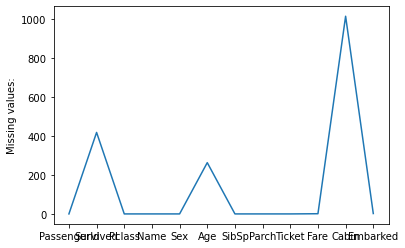

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


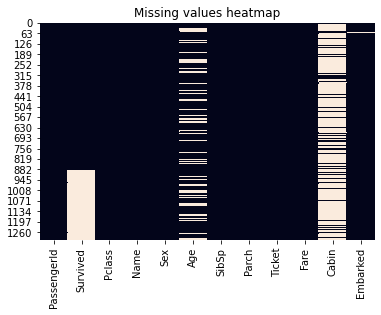

In [3]:
print("Colums: ", data_train.columns.values)
print("Shape: ", data.shape)

# Missing values
plt.ylabel("Missing values:")
plt.plot(pd.DataFrame(data.isnull().sum()))
plt.show()
print(data.isnull().sum())

sns.heatmap(data.isnull(), cbar=False).set_title("Missing values heatmap")
plt.show()


# Feature Engineering

Categorical:

* Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.
* Numerical: Age, Fare. Discrete: SibSp, Parch.
* Nullable: Survived, Age, Cabin, Embarked

# PClass
Description

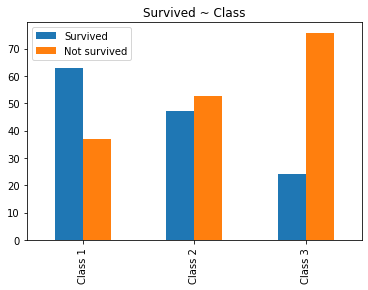

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [4]:
pClass_1 = round(
    (data_train[data_train.Pclass == 1].Survived == 1).value_counts()[1] /
    len(data_train[data_train.Pclass == 1]) * 100, 2)
pClass_2 = round(
    (data_train[data_train.Pclass == 2].Survived == 1).value_counts()[1] /
    len(data_train[data_train.Pclass == 2]) * 100, 2)
pClass_3 = round(
    (data_train[data_train.Pclass == 3].Survived == 1).value_counts()[1] /
    len(data_train[data_train.Pclass == 3]) * 100, 2)

pClassDf = pd.DataFrame(
    {"Survived": {"Class 1": pClass_1,
                  "Class 2": pClass_2,
                  "Class 3": pClass_3},
     "Not survived": {"Class 1": 100 - pClass_1,
                      "Class 2": 100 - pClass_2,
                      "Class 3": 100 - pClass_3}})
pClassDf.plot.bar().set_title("Survived ~ Class")
plt.show()

data_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Sex 
Description

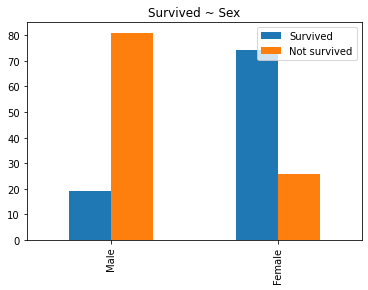

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [5]:
sex_1 = round(
    (data_train[data_train.Sex == 'male'].Survived == 1).value_counts()[1] /
    len(data_train[data_train.Sex == 'male']) * 100, 2)
sex_2 = round(
    (data_train[data_train.Sex == 'female'].Survived == 1).value_counts()[1] /
    len(data_train[data_train.Sex == 'female']) * 100, 2)

pClassDf = pd.DataFrame(
    {"Survived": {"Male": sex_1,
                  "Female": sex_2},
     "Not survived": {"Male": 100 - sex_1,
                      "Female": 100 - sex_2}})
pClassDf.plot.bar().set_title("Survived ~ Sex")
plt.show()

data_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# SibSp
Description

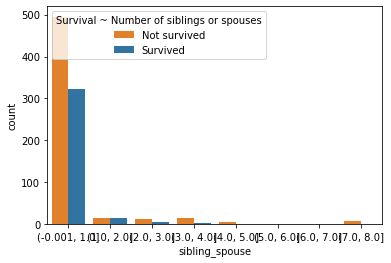

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [6]:
ss = pd.DataFrame()
ss['survived'] = data_train.Survived
ss['sibling_spouse'] = pd.cut(data_train.SibSp, [0, 1, 2, 3, 4, 5, 6, 7, 8], include_lowest=True)

x = sns.countplot(x="sibling_spouse", hue="survived", data=ss, palette=["C1", "C0"]).legend(
    labels=["Not survived", "Survived"])
x.set_title("Survival ~ Number of siblings or spouses")
plt.show()

data_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Parch
Description

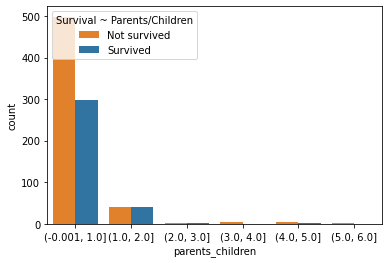

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [7]:
pc = pd.DataFrame()
pc['survived'] = data_train.Survived
pc['parents_children'] = pd.cut(data_train.Parch, [0, 1, 2, 3, 4, 5, 6], include_lowest=True)
x = sns.countplot(x="parents_children", hue="survived", data=pc, palette=["C1", "C0"]).legend(
    labels=["Not survived", "Survived"])

x.set_title("Survival ~ Parents/Children")
plt.show()

data_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Age
Description

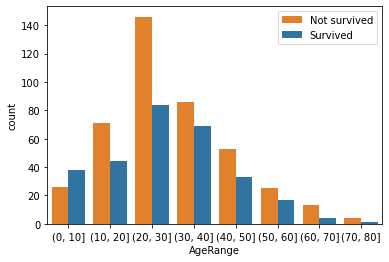

In [8]:
data['AgeRange'] = pd.cut(data.Age, [0, 10, 20, 30, 40, 50, 60, 70, 80])
sns.countplot(x="AgeRange", hue="Survived", data=data, palette=["C1", "C0"]).legend(labels=["Not survived", "Survived"])
plt.show()

# Fare
Description

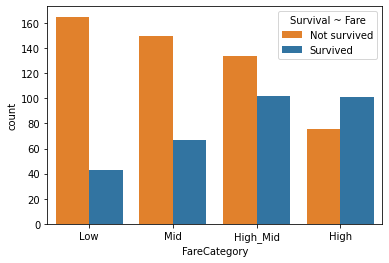

In [9]:
data['FareCategory'] = pd.cut(data_train['Fare'], bins=[0, 7.90, 14.45, 31.28, 120], labels=['Low', 'Mid',
                                                                                                    'High_Mid', 'High'])
x = sns.countplot(x="FareCategory", hue="Survived", data=data, palette=["C1", "C0"]).legend(
    labels=["Not survived", "Survived"])
x.set_title("Survival ~ Fare")

# Embarked
Desrcipton

Text(0.5, 1.0, 'Survival ~ Embarking.')

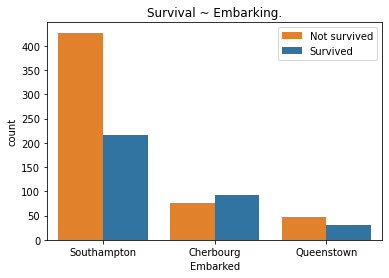

In [10]:
p = sns.countplot(x="Embarked", hue="Survived", data=data_train, palette=["C1", "C0"])
p.set_xticklabels(["Southampton", "Cherbourg", "Queenstown"])
p.legend(labels=["Not survived", "Survived"])
p.set_title("Survival ~ Embarking.")

# Family
Description

In [11]:
data['Family'] = data.Parch + data.SibSp
data['IsAlone'] = data.Family == 0
data['SmallFamily'] = data['Family'].map(lambda s: 1 if 1 <= s <= 3 else 0)
data['BigFamily'] = data['Family'].map(lambda s: 1 if 4 <= s else 0)

# Salutation

In [12]:
data['Salutation'] = data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
print(data.Salutation.unique())
data.Salutation.nunique()

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


18

# Naming

In [13]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in data["Name"]]
data['Title']=data.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

data['Title']=data.Title.map(newtitles)

data['Mother'] = (data['Title'] == 'Mrs') & (data['Parch'] > 0)
data['Mother'] = data['Mother'].astype(int)

# Age
Missing values

In [14]:
grp = data.groupby(['Sex', 'Pclass', 'Title'])
data.Age = grp.Age.apply(lambda x_: x_.fillna(x_.median()))
data.Age.fillna(data.Age.median, inplace=True)

data['AgeRange'] = pd.cut(data['Age'].astype(int), 5)

# Ticket

In [15]:
data['Ticket_Lett'] = data['Ticket'].apply(lambda x: str(x)[0])
data['Ticket_Lett'] = data['Ticket_Lett'].apply(lambda x: str(x))
data['Ticket_Lett'] = np.where((data['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), data['Ticket_Lett'],
                                   np.where((data['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
data['Ticket_Len'] = data['Ticket'].apply(lambda x: len(x))

# Fare
Missing values

In [16]:
data.Fare.fillna(data.Fare.mean(), inplace = True)
# data['FareCategory'] = pd.qcut(data['Fare'], 4)

# Embarked
Missing values

In [17]:
data.Embarked.fillna(data.Embarked.mode()[0], inplace = True)

# Cabin
Missing values

In [18]:
data.Cabin.fillna('NA', inplace=True)

data['Cabin'] = data['Cabin'].map(lambda s: s[0])

# Label encorder

In [19]:

data['Title'] = LabelEncoder().fit_transform(data['Title'])

data = pd.concat([data,
                pd.get_dummies(data.Cabin, prefix="Cabin"),
                pd.get_dummies(data.AgeRange, prefix="AgeRange"), 
                pd.get_dummies(data.Embarked, prefix="Embarked", drop_first = True),
                pd.get_dummies(data.Title, prefix="Title", drop_first = True),
                pd.get_dummies(data.FareCategory, prefix="Fare", drop_first = True), 
                pd.get_dummies(data.Ticket_Lett, prefix="Ticket", drop_first = True), 
                pd.get_dummies(data.Pclass, prefix="Class", drop_first = True)], axis=1)

data['IsAlone'] = LabelEncoder().fit_transform(data['IsAlone'])
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])


In [20]:
data.drop(['Pclass', 'Fare','Cabin', 'FareCategory','Name','Salutation', 'Ticket_Lett', 'Ticket','Embarked', 'AgeRange', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)

In [21]:
print("Colums: ", data.columns.values)

Colums:  ['PassengerId' 'Survived' 'Sex' 'Family' 'IsAlone' 'SmallFamily'
 'BigFamily' 'Title' 'Mother' 'Ticket_Len' 'Cabin_A' 'Cabin_B' 'Cabin_C'
 'Cabin_D' 'Cabin_E' 'Cabin_F' 'Cabin_G' 'Cabin_N' 'Cabin_T'
 'AgeRange_(-0.08, 16.0]' 'AgeRange_(16.0, 32.0]' 'AgeRange_(32.0, 48.0]'
 'AgeRange_(48.0, 64.0]' 'AgeRange_(64.0, 80.0]' 'Embarked_Q' 'Embarked_S'
 'Title_1' 'Title_2' 'Title_3' 'Title_4' 'Title_5' 'Fare_Mid'
 'Fare_High_Mid' 'Fare_High' 'Ticket_2' 'Ticket_3' 'Ticket_A' 'Ticket_C'
 'Ticket_Low_ticket' 'Ticket_Other_ticket' 'Ticket_P' 'Ticket_S' 'Class_2'
 'Class_3']


In [22]:
import sklearn


# Prediction

X_pred = data[data.Survived.isnull()].drop(['Survived'], axis=1)

# Training data

train_data = data.dropna()
X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler



clf = GradientBoostingClassifier(learning_rate=0.1,
                                 n_estimators=700,
                                 max_depth=2)

clf.fit(X_train, np.ravel(y_train))
print("RF Accuracy: " + repr(round(clf.score(X_test, y_test) * 100, 2)) + "%")

result_rf = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print('The cross validated score for Random forest is:', round(result_rf.mean() * 100, 2))
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)

RF Accuracy: 81.01%
The cross validated score for Random forest is: 81.32


In [24]:
# Random forest
# entropy
# gini

clf = RandomForestClassifier(criterion='entropy',
                             n_estimators=700,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             max_features = "auto",
                             oob_score=True,
                             random_state=0,
                             n_jobs=-1)

clf.fit(X_train, np.ravel(y_train))
print("RF Accuracy: " + repr(round(clf.score(X_test, y_test) * 100, 2)) + "%")

result_rf = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print('The cross validated score for Random forest is:', round(result_rf.mean() * 100, 2))
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)


RF Accuracy: 80.45%
The cross validated score for Random forest is: 83.99


In [25]:
result = clf.predict(X_pred)
submission = pd.DataFrame({'PassengerId':X_pred.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'TitanicPredictions4.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: TitanicPredictions4.csv
